In [0]:
import json
import cv2
import matplotlib.pyplot as plt
import re
import collections
import pandas as pd
import numpy as np


In [3]:
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.models import Model,load_model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Input,Dense,Dropout,Embedding,LSTM
from keras.layers.merge import add
from time import time
import pickle
import string
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input,Dense,LSTM,Dropout,Embedding


Using TensorFlow backend.


In [0]:
#### reading the textfiles(captions)

In [0]:
def readText(path):
    with open(path) as f:
        captions=f.read()
        
    return captions

In [0]:
captions=readText("/content/drive/My Drive/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions=captions.split("\n")[:-1] ### discarding the last line
###### last line is empty

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
len(captions) ############ here we can easily read the caption

40460

In [9]:
print(captions[0])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [10]:
first,second=captions[0].split('\t')   ## extracting the image id of the caption
print(first)
print(second)
print(first.split('.')[0])  ## exact image id

1000268201_693b08cb0e.jpg#0
A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e


In [0]:
#### lets create a dictionary to map each image with the list of captions it has
dictionary={}  ## dictionary for mapping

for cap in captions:
    first,second=cap.split('\t')  
    img_name=first.split('.')[0]
    
    
    ### if the image id is already present or not
    if dictionary.get(img_name) is None:
        dictionary[img_name]=[]  ## here with particular img if no caption is added the we initialise with empty list
        
        
    dictionary[img_name].append(second) ### if the image is already present than add it to a list(append the caption to that image id)

In [12]:
dictionary["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [0]:
img_path="/content/drive/My Drive/caption/Images/"

In [0]:
### checking how images look like 

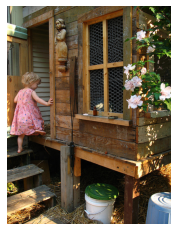

In [15]:
img=cv2.imread(img_path+"1000268201_693b08cb0e.jpg")
img_=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img_)
plt.axis("OFF")
plt.show()

### cleaning the Text

In [0]:
### here we should not remove stopwords and  does not do stemming to produce correct caption(as order of word matters)

### cleaning the text
def clean_text(sentence):
    sentence=sentence.lower() ### so that "the The" remain same
    sentence=re.sub("[^a-z]+"," ",sentence)  ### subsitute space if any of charcater is present other alphabets
    sentence=sentence.split()  ## splitting the sentence into words
    print(sentence)
    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)  ## joining it again
    return sentence

### cleaning all the captions

In [1]:


#for key,caption_list in dictionary.items():
    
  #  for i in range(len(caption_list)):
     #   caption_list[i]=clean_text(caption_list[i])
        


In [18]:
dictionary["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

### save our preprocessing part

In [0]:
with open("descriptions_new1.txt","w") as f:
    f.write(str(dictionary)) ## dictionary with your clean data is saved into your file
    
    ###########################                         CLEAN DATA IS SAVED INTO THE FILE                       ##########################

### VOCABULARY

In [0]:
descriptions=None
with open("descriptions_new1.txt","r") as f:
    descriptions=f.read()

In [21]:
print(type(descriptions))

<class 'str'>


### coverting this str to dict type we will require json 

In [0]:
json_accpetable_string=descriptions.replace("'","\"")
descriptions=json.loads(json_accpetable_string) ## for converting it to dictionary


In [23]:
print(type(descriptions))

<class 'dict'>


In [0]:
## vocab

vocab=set() ## stores the unique word(finfing unique words in the captions)

for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]] 
    
    
    ### keeping only those words in the dictionary which are unique so that we can create a effective vocab size

In [25]:
len(vocab) 

### total unique words present in the captions list

8424

### we will remove very infrequent words so that our vocab size reduces

## counting the total words

In [26]:
## keeping only those words in the vocab which are very very important(occurs more than a threshold value)

total_words=[]

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

    
    ### here "des" is the list of the captios where as "i" is the word in that particular caption and we append it in total_words
print(len(total_words))

373837


### filter the words from the vocab which have frequency greater than some threshold frequency

### only 8424 words are unique

In [0]:
counter=collections.Counter(total_words)### it will give you the frequency of each word
freq_cnt=dict(counter)


### sorting the dict according to the freq_cnt

In [0]:
sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])


### now filteration
threshold=10
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold ]  ## only adding words which have frequency count greater than 10

total_words=[x[0] for x in sorted_freq_cnt]  ## final vocab

In [29]:
print(len(total_words))


1845


### preparing train and test data

In [0]:
train_file_data=readText("/content/drive/My Drive/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data=readText("/content/drive/My Drive/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [0]:

train=[row.split('.')[0] for row in train_file_data.split("\n")[:-1]]
test=[row.split('.')[0] for row in test_file_data.split("\n")[:-1]]

In [32]:

print(train[:10])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154']


## we have to add start and end token to our training data to stop generating the sentence or when generating multiple sentences

In [0]:
train_descriptions={} ## subset of descriptions dictionary

for img_id in train:
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_app="startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_app)

In [34]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Creating our model Through transfer learning

In [35]:
model=ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

102858752/102853048 [==============================] - 9s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
________________________

In [0]:
model_new=Model(model.input,model.layers[-2].output)

In [0]:
def preprocess_img(img):
    img= image.load_img(img,target_size=(224,224))
    img= image.img_to_array(img)    ### when you feed an image to resnet you can not feed single image you have to feed by batch
                                   #### which creates a 4d tensor   
    img= np.expand_dims(img,axis=0)  ## it creates 4d tensor
    
    ### normalisation
    img=preprocess_input(img)  ## preprocessing done by keras by subtracting mean (see documentation)
    
    return img
    

### this the Resnet50 way of representing the picture using some normalisation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


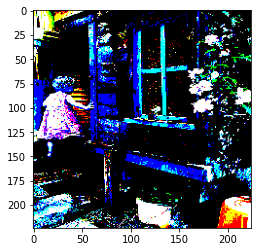

In [38]:
img=preprocess_img(img_path+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.show()

In [0]:
def encode_img(img):
    img=preprocess_img(img)
    feature_vector=model_new.predict(img)
    feature_vector=feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector
    

In [40]:
x=img_path+"1000268201_693b08cb0e.jpg"
print(x)
encode_img(x)

/content/drive/My Drive/caption/Images/1000268201_693b08cb0e.jpg


array([0.04154297, 0.17076068, 0.2927861 , ..., 0.05089626, 0.3132238 ,
       0.86007506], dtype=float32)

### now we have to do encoding for each of the image and we have to save it

In [0]:
### here encoding train is a dictionary where each of the image_id is mapped with the feature vector extracted from resnet50 model

In [42]:
encoding_train={}
start=time()
for ix,img_id in enumerate(train):
    IMG_path=img_path+img_id+".jpg"
    encoding_train[img_id]=encode_img(IMG_path)  ### extracting feature vector for the image and mapping it with the image id
    
    
    if ix%100==0:
        print(" encoding in progress %d "%ix)
        
        
end_t=time()
#print("%d"%end_t-start)

 encoding in progress 0 
 encoding in progress 100 
 encoding in progress 200 
 encoding in progress 300 
 encoding in progress 400 
 encoding in progress 500 
 encoding in progress 600 
 encoding in progress 700 
 encoding in progress 800 
 encoding in progress 900 
 encoding in progress 1000 
 encoding in progress 1100 
 encoding in progress 1200 
 encoding in progress 1300 
 encoding in progress 1400 
 encoding in progress 1500 
 encoding in progress 1600 
 encoding in progress 1700 
 encoding in progress 1800 
 encoding in progress 1900 
 encoding in progress 2000 
 encoding in progress 2100 
 encoding in progress 2200 
 encoding in progress 2300 
 encoding in progress 2400 
 encoding in progress 2500 
 encoding in progress 2600 
 encoding in progress 2700 
 encoding in progress 2800 
 encoding in progress 2900 
 encoding in progress 3000 
 encoding in progress 3100 
 encoding in progress 3200 
 encoding in progress 3300 
 encoding in progress 3400 
 encoding in progress 3500 
 enc

In [74]:
print(img_path)

/content/drive/My Drive/caption/Images/


#### storing it into a disk
#### pickle allows you to switch between Ram and file

In [0]:
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [45]:
encoding_test={}
start=time()
for ix,img_id in enumerate(test):
    IMG_path=img_path+img_id+".jpg"
    encoding_test[img_id]=encode_img(IMG_path)
    
    
    if ix%100==0:
        print(" encoding in progress %d "%ix)
        
        
end_t=time()
#print("%d"%end_t-start)

 encoding in progress 0 
 encoding in progress 100 
 encoding in progress 200 
 encoding in progress 300 
 encoding in progress 400 
 encoding in progress 500 
 encoding in progress 600 
 encoding in progress 700 
 encoding in progress 800 
 encoding in progress 900 


In [0]:
with open("encoded_test_features2.pkl","wb") as f:
    pickle.dump(encoding_train,f)

### data preprocessing for the captions

### mapping words with numbers to feed into our model

whenever we are feeding data to our model every word is feature and each word must be converted to a number as our  model works on the numbers only 

In [0]:
word_to_idx={}
idx_to_word={}

for i,word in enumerate(total_words):
    word_to_idx[word]=i+1   ### mapping word with number
    idx_to_word[i+1]=word   ### then number with the word(when we want to at the other what is the word)

### we have to add two special words

In [0]:
idx_to_word[1846]="startseq"
word_to_idx["startseq"]=1846
                                    ### these words are not in the dictionary
idx_to_word[1847]="endseq"
word_to_idx["endseq"]=1847

In [49]:
vocab_size=len(word_to_idx)+1
print(vocab_size)

1848


### we have 1848 in our final vocab includeing words start and endseq

## from captions we have to find some max caption which can determine the batch_size

In [50]:
maxlen=0

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        maxlen=max(maxlen,len(cap.split()))
        
print(maxlen)

35


## data loader

In [51]:
word_to_idx["in"]

1

In [52]:
idx_to_word[100]

'dirt'

### our conecpt is to predict next word such that that we have already seen the past words -Langiage Modellling

In [0]:
def data_generator(train_descriptions,encoding_train,word_to_idx,maxlen,batch_size):
    X1,X2,y=[],[],[]
    
    n=0
    while True:
        for key,dec_list in train_descriptions.items():
            n+=1
            photo=encoding_train[key]
            for desc in dec_list:
                seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx] ## converting list of numbers of the words which are present
                ### for all other unknown words we are just going to ignore the words which are not present in word_to_idx
                ### [13 46 64 83 19 ]
                ### len is 5
                ### so everytime we take one number more from the list
                ### 13                 ### given seq 13 your yi(y_pred ) should be 46
                ### 13 46              ### given seq 13 46 your yi(y_ored ) should be 13 46 64 and so on
                ### 13 46 64 
                ### 13 46 83 19
                for i in range(1,len(seq)):
                    xi=seq[0:i]
                    yi=seq[i]
                   
                    ## xero is the padded word
                    
                    xi=pad_sequences([xi],maxlen=maxlen,value=0,padding='post')[0] ### we are doing padding so that every xi is of same length
                    ## pad_sequences accept 2-d matrix 
                    yi=to_categorical([yi],num_classes=vocab_size)[0]  ### one hot vector for neural network
                    
                    ## here xi and yi  gives us the one data point
                    
                    
                    X1.append(photo)
                    X2.append(xi)      ### here we are making a batch
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]  ### see generators concept
                    X1,X2,y=[],[],[]  ### we do not want to add examples which are there in previous batch 
                    n=0
                    

### transfer learning for captions

In [0]:
### till now what we have done s 
### the conversion of sentences example
### the dog is running ===== the-23 ,dog-45,is-2,running-67
### now each word will a 50-dimensional vector and we will make a embedding matrix of it

In [0]:
f=open("/content/drive/My Drive/glove6b50dtxt/glove.6B.50d.txt",encoding='utf8')


In [0]:
embedding_index={}  ### this dictionary will store vector for every word

for line in f:
    values=line.split()
    #print(values) ### see this 
    #break
    word=values[0] ### first will be the word and next 50 things will be the vector
    word_embedding=np.array(values[1:],dtype='float')
    embedding_index[word]= word_embedding

### here we have 6 billion words but we want embeddings for the words are there in our vocab

In [79]:
print(vocab_size)

1848


In [0]:
def get_Embedding_matrix():
    emd_dim=50
    ##vocab_size=1848
    matrix=np.zeros((vocab_size,emd_dim))
    
    
    for word,idx in word_to_idx.items():
        embedding_vector=embedding_index.get(word)  ## here you get the vector from the embedding_index
        
        
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
            ### whatever be the idx of the word ,paste the embedding vector at that index in the matrix
    return matrix

In [0]:
f.close()

In [82]:
print(embedding_index['apple'])

[ 0.52042  -0.8314    0.49961   1.2893    0.1151    0.057521 -1.3753
 -0.97313   0.18346   0.47672  -0.15112   0.35532   0.25912  -0.77857
  0.52181   0.47695  -1.4251    0.858     0.59821  -1.0903    0.33574
 -0.60891   0.41742   0.21569  -0.07417  -0.5822   -0.4502    0.17253
  0.16448  -0.38413   2.3283   -0.66682  -0.58181   0.74389   0.095015
 -0.47865  -0.84591   0.38704   0.23693  -1.5523    0.64802  -0.16521
 -1.4719   -0.16224   0.79857   0.97391   0.40027  -0.21912  -0.30938
  0.26581 ]


In [83]:
mat=get_Embedding_matrix()
print(mat.shape) ## every word has a 50 dimensional vector 

(1848, 50)


### Model Architecture

### this is not a sequential model we are doing branching and using keras functional api

In [0]:
input_img_f=Input(shape=(2048,)) ### the output of resnet is given to the input layer(with alreday extracted features)
inp_img1=Dropout(0.3)(input_img_f)
inp_img2=Dense(256,activation='relu')(inp_img1) ## output of previous to the input(this is how you define flow of tensors )
## converting the 2048dim to 256 dim 

### this inp_img2 represents your image 


### captions

In [0]:
input_captions=Input(shape=(maxlen,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

##3 here you have input-> then embedding layer than -> LSTM model 

In [0]:

### now we have a decoder which gets a concatenated vector of two vectors 
### one from image feature vector and one vecctor we have generated through glove embeddings

In [87]:
decoder1=add([inp_img2,inp_cap3]) ### one is from the image and the other is from the captions we have generated 
### and then we concatenate them
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

################                             combined model #######################

model=Model([input_img_f,input_captions],outputs=outputs)
model.summary()
### nno parametre for add layer because we are just adding two layers


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 50)       92400       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

### Important Thing -Embedding Layer(preintialise it )

In [0]:
model.layers[2].set_weights([mat])   ### the weights we have generated through our vocab and glove embeddings
model.layers[2].trainable=False      #### as we are using preinitialise weights we do not train it


In [0]:
model.compile(loss='categorical_crossentropy',optimizer='adam')


In [0]:
### here there is no evolution matrix as -:
### let suppose you have predict  that dog is running on the grass
### and the actual pred is dog is running 
### so both are same you can not differentiate between them and get accuracy

In [0]:
epochs=20
batch_size=3
number_of_pics_per_batch=3
steps=len(train_descriptions)//number_of_pics_per_batch

In [0]:
def train():
    
    
    for i in range(epochs):
        generator=data_generator(train_descriptions,encoding_train,word_to_idx,maxlen,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('/content/drive/My Drive/model_weights/model_'+str(i)+'.h5')

In [104]:
train()

Epoch 1/1
2000/2000 [==============================] - 281s 141ms/step - loss: 2.3886
Epoch 1/1
2000/2000 [==============================] - 281s 140ms/step - loss: 2.3856
Epoch 1/1
2000/2000 [==============================] - 280s 140ms/step - loss: 2.3853
Epoch 1/1
2000/2000 [==============================] - 281s 140ms/step - loss: 2.3832
Epoch 1/1
2000/2000 [==============================] - 278s 139ms/step - loss: 2.3793
Epoch 1/1
2000/2000 [==============================] - 276s 138ms/step - loss: 2.3731
Epoch 1/1
2000/2000 [==============================] - 277s 139ms/step - loss: 2.3707
Epoch 1/1
2000/2000 [==============================] - 278s 139ms/step - loss: 2.3664
Epoch 1/1
2000/2000 [==============================] - 281s 140ms/step - loss: 2.3634
Epoch 1/1
2000/2000 [==============================] - 280s 140ms/step - loss: 2.3621
Epoch 1/1
2000/2000 [==============================] - 278s 139ms/step - loss: 2.3567
Epoch 1/1
2000/2000 [==============================] -

In [0]:
print(encoding_train)

<_io.TextIOWrapper name='/content/drive/My Drive/encoded_train_features.pkl' mode='r' encoding='UTF-8'>


In [0]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(maxlen):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=maxlen,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

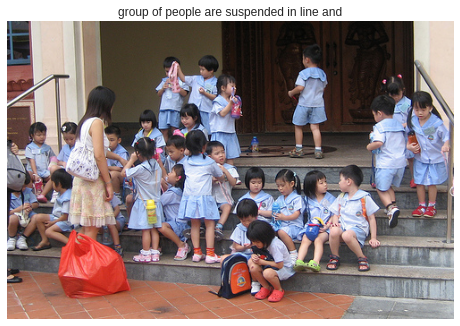

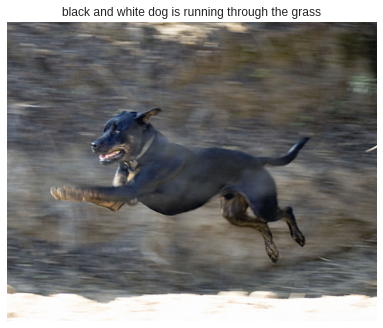

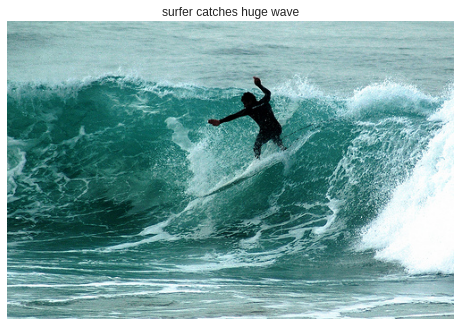

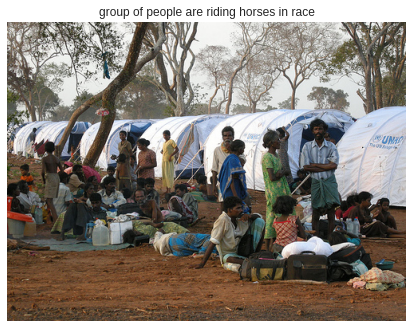

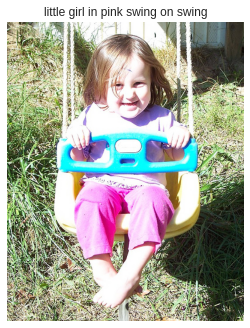

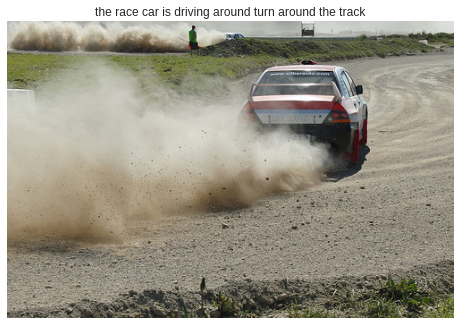

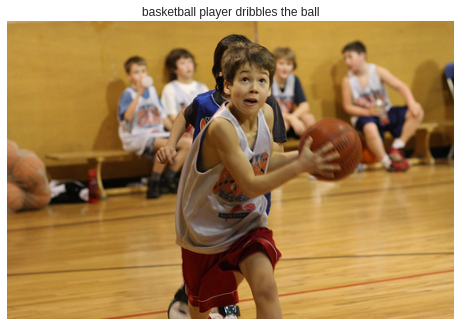

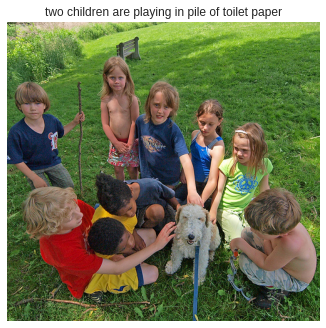

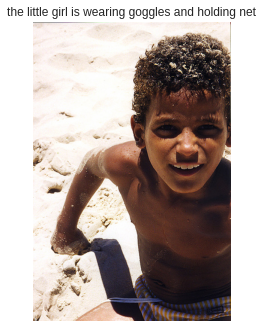

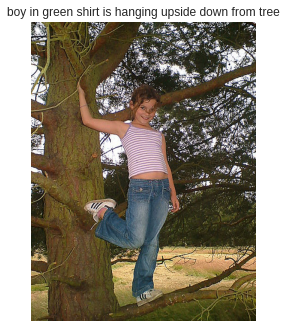

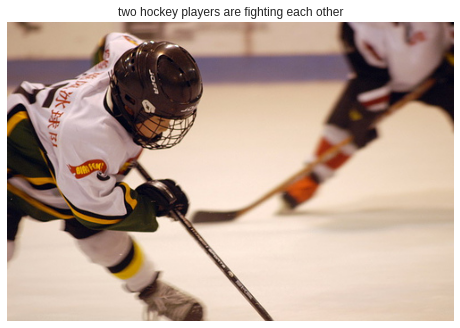

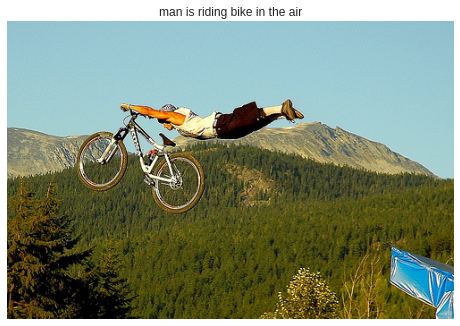

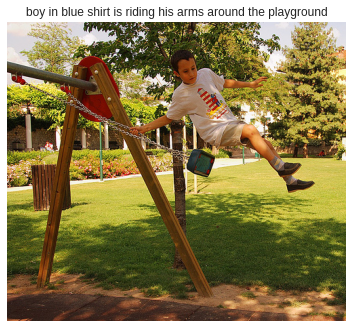

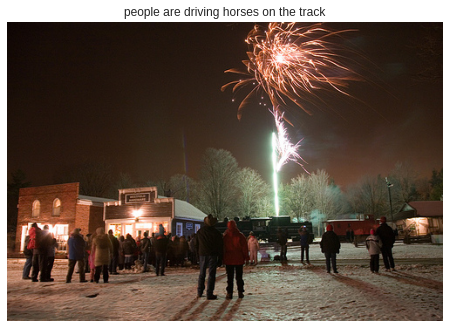

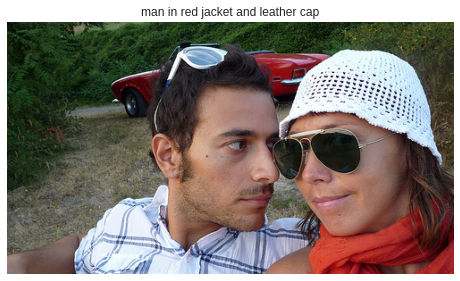

In [107]:
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("/content/drive/My Drive/caption/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()